In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
from torch.autograd import Variable
import sys
import os
from sklearn import metrics
import save_load_util as pa

In [66]:
#This determines what run we want to visualize. It is important to import model and data functions specific to that run as well.
path = '/data4/jeeheh/ShadowPeriod/pytorchLSTM/inprog6/'
from pytorchLSTM.inprog6 import model as custom_model
from pytorchLSTM.inprog6 import data as custom_data

In [67]:
#Load Files from Run
pred = pd.read_hdf(path+'/data.h5','pred')
traintestloss = pd.read_hdf(path+'/data.h5','traintestloss')
with open(path+'/args.pkl', 'rb') as f: args = pickle.load(f)

In [68]:
args={}
args['nrep'] = 1000
args['lower']=np.around(.025*args['nrep'],decimals=0).astype(int)
args['upper']=np.around(.975*args['nrep'],decimals=0).astype(int)
args['data_loc'] = '/data4/jeeheh/ShadowPeriod/Data/Adult_fulldata_2_14_19_v16 - labs and meds fixed - Without Procedures BMI Fixed/'

### HP Search Settings

In [69]:
pred.loc[:,['num_param','batch_size','learning_rate','l2','hidden_size','randominit']].drop_duplicates()

,num_param,batch_size,learning_rate,l2,hidden_size,randominit
0,57462002,75,0.10,0.01,1500,0
70068,44529602,25,0.01,0.10,1200,1


## Best Performance

In [70]:
display(traintestloss.loc[traintestloss.valauc.idxmax(),:])

testauc       0.759998
valauc        0.828608
trainauc      0.783193
testloss      0.015387
valloss       0.015664
trainloss     0.015093
epoch         7.000000
randominit    0.000000
Name: 6, dtype: float64

In [71]:
traintestloss.loc[traintestloss.testauc.idxmax(),:]

testauc       0.768382
valauc        0.813669
trainauc      0.752044
testloss      0.015484
valloss       0.016858
trainloss     0.016458
epoch         2.000000
randominit    0.000000
Name: 1, dtype: float64

### AUROC Curves

In [72]:
def empBSCI_OLD(stat_bs,stat,ci):
    #calculates the empirical bootstrap confidence interval
    #stat_bs is the bootstrapped estimate: mean, auroc, aupr etc.
    #stat is the non bootstrapped estimate
    stat2=stat_bs-stat #this is elementwise
    upper=100-(100-ci)/2.0 #upper percentile
    lower=(100-ci)/2.0 #lower percentile
    upperci=np.percentile(stat2,upper)
    lowerci=np.percentile(stat2,lower)
    return stat-upperci, stat-lowerci #lower bound, upper bound

def empBSCI(stat_bs, ci):                                                                                                                                                            
    #calculates the empirical bootstrap confidence interval                                                                                                                          
    #stat_bs is the bootstrapped estimate: mean, auroc, aupr etc.                                                                                                                    
    #stat is the non bootstrapped estimate                                                                                                                                           
    upper=100-(100-ci)/2.0 #upper percentile                                                                                                                                         
    lower=(100-ci)/2.0 #lower percentile                                                                                                                                             
    upperci=np.percentile(stat_bs,upper)                                                                                                                                             
    lowerci=np.percentile(stat_bs,lower)                                                                                                                                             
    return lowerci, upperci   

def AUROC(df2,noci=False):

    if noci:
        fpr,tpr,_=metrics.roc_curve(df2['labels'],df2['outputs'],pos_label=1)
        auroc=metrics.auc(fpr,tpr)
        return auroc
    
    else:
        #Bootstrap 95% CI
        np.random.seed(124)
        bootstrap=np.random.choice(len(df2),(args['nrep'],len(df2)),replace=True)

        aurocbs=np.empty(args['nrep'])
        aurocbs[:]=np.nan
        for i in range(args['nrep']):
            fpr, tpr, _=metrics.roc_curve(df2.iloc[bootstrap[i,:],df2.columns.get_loc('labels')],
                                          df2.iloc[bootstrap[i,:],df2.columns.get_loc('outputs')],pos_label=1)
            aurocbs[i]=metrics.auc(fpr, tpr)
        zauroc=np.argsort(aurocbs) #sorts smallest to largest

        lowerindx=bootstrap[zauroc[args['lower']],:]
        upperindx=bootstrap[zauroc[args['upper']],:]

        fpr_lower, tpr_lower,_=metrics.roc_curve(df2.iloc[lowerindx,df2.columns.get_loc('labels')],
                                                 df2.iloc[lowerindx,df2.columns.get_loc('outputs')],pos_label=1)
        fpr_upper,tpr_upper,_=metrics.roc_curve(df2.iloc[upperindx,df2.columns.get_loc('labels')],
                                                df2.iloc[upperindx,df2.columns.get_loc('outputs')],pos_label=1)
        auroc_lower=metrics.auc(fpr_lower,tpr_lower)
        auroc_upper=metrics.auc(fpr_upper,tpr_upper)

        #ROC
        fpr,tpr,_=metrics.roc_curve(df2['labels'],df2['outputs'],pos_label=1)
        auroc=metrics.auc(fpr,tpr)

        #Plot - No Train
        plt.figure()
        plt.plot(fpr,tpr,label='Test AUROC=%0.2f' %auroc)
        plt.plot(fpr_lower,tpr_lower,'b--')#lower
        plt.plot(fpr_upper,tpr_upper,'b--')#upper

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.axis([0,1,0,1])
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
        # plt.savefig(pathfig+'auroc-noTrain.eps',format='eps',dpi=300)
        # plt.savefig(pathfig+'auroc-noTrain.png',format='png',dpi=300)
        plt.clf()

        auroc_lower,auroc_upper=empBSCI(aurocbs,95)

        print('AUROC Test Upper: {}'.format(auroc_upper))
        print('AUROC Test: {}'.format(auroc))
        print('AUROC Test Lower: {}'.format(auroc_lower))

        return fpr, tpr

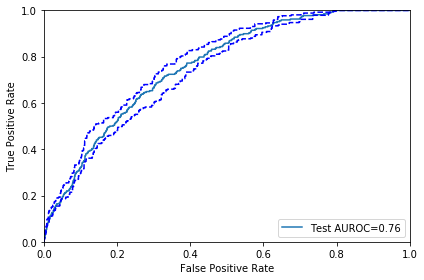

AUROC Test Upper: 0.7853664130879533
AUROC Test: 0.7599977221419473
AUROC Test Lower: 0.7366117423414844


<Figure size 432x288 with 0 Axes>

In [75]:
best_randominit=0
fpr,tpr = AUROC(pred.loc[(pred.dataset=='test')&(pred.randominit==best_randominit),:])

## Train/Val/Test

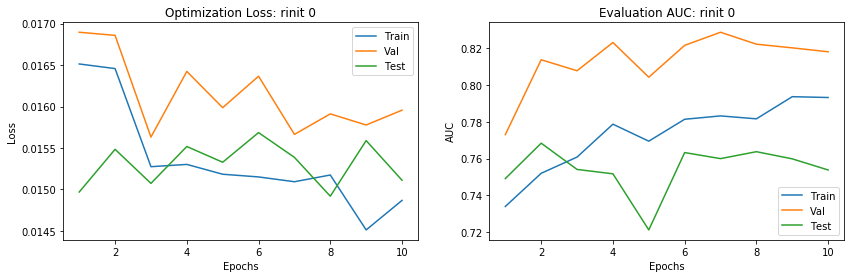

<Figure size 432x288 with 0 Axes>

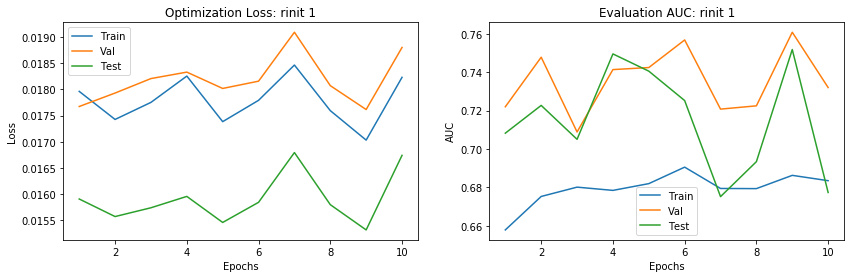

<Figure size 432x288 with 0 Axes>

In [74]:
for randominit in traintestloss.randominit.unique():
    fig, ax = plt.subplots(1,2,figsize=(14,4))
    zdf = traintestloss.loc[traintestloss.randominit==randominit,:]
    ax[0].plot(zdf.epoch, zdf.trainloss, label='Train')
    ax[0].plot(zdf.epoch, zdf.valloss, label='Val')
    ax[0].plot(zdf.epoch, zdf.testloss, label='Test')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Optimization Loss: rinit '+str(randominit))
    ax[0].legend()
    
    ax[1].plot(zdf.epoch, zdf.trainauc, label='Train')
    ax[1].plot(zdf.epoch, zdf.valauc, label='Val')
    ax[1].plot(zdf.epoch, zdf.testauc, label='Test')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Evaluation AUC: rinit '+str(randominit))
    ax[1].set_ylabel('AUC')
    plt.show()
    plt.clf()

In [45]:
_, _, _, _, trainref, _, refcols, _, _, _ = pa.load_all('xtrain.npz', 'xtest.npz', 'labels_and_references.npz', 'cols_and_hist.pkl',args['data_loc'])

In [50]:
zdf = pd.DataFrame({'eid':trainref[:,refcols['EncounterID']],
                    'AdmitDate': trainref[:,refcols['AdmitDate']]})
zdf['Year'] = zdf.AdmitDate.dt.year
zdf = pred.merge(zdf, how='left', on='eid')

In [64]:
for randominit in zdf.randominit.unique():
    print('rinit: ',randominit)
    zdf2 = zdf.loc[(zdf.randominit==randominit)&(zdf.dataset=='val'),:]
    for year in zdf2['Year'].unique():
        print('{:.0f}: {:.5f}'.format(year, AUROC(zdf2.loc[zdf2.Year==year,:],noci=True)))

rinit:  0
2013: 0.97549
2014: 0.96084
2016: 0.97065
2015: 0.94488
2017: 0.92572
rinit:  1
2013: 0.70080
2014: 0.67967
2016: 0.73647
2015: 0.73213
2017: 0.72370
